In [124]:
import os
import nibabel as nib
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.glm.first_level import make_first_level_design_matrix, run_glm
from nilearn.glm.contrasts import compute_contrast

from utils.psth import map_events_to_frame_times, get_trial_data, normalize_data

In [114]:
def get_task_idx(mat_data, task_type):
    for i, row in enumerate(mat_data['files_ML']['name']):
        filename = row[0][0]  
        
        if task_type.lower() == "audio" and ("audio" in filename.lower() or "aduio" in filename.lower()):
            return i
        if task_type.lower() == "video" and "video" in filename.lower():
            return i

    return None


def load_data(data_dir, brain_filename, event_filename, task_type='video'):
    brain_file = os.path.join(data_dir, brain_filename)
    event_file = os.path.join(data_dir, event_filename)

    brain_img = nib.load(brain_file)
    brain_data = brain_img.get_fdata()
    print(f"Brain data shape: {brain_data.shape}")

    mat_data = sio.loadmat(event_file)
    i = get_task_idx(mat_data, task_type)
    event_mat = mat_data['mldata'][0][i][0]

    return brain_data, event_mat

In [115]:
# Function to extract event-related information
def extract_event_info(event_mat, task_type='video'):
    if task_type == 'video':
        condition = event_mat[:]["Block"]
    elif task_type == 'audio':
        condition = event_mat[:]["Condition"]
    else:
        raise ValueError("Invalid task type. Must be 'video' or 'audio'")
    behave_codes = event_mat[:]["BehavioralCodes"]
    absolute_starttime = event_mat[:]["AbsoluteTrialStartTime"]
    return condition, behave_codes, absolute_starttime

In [116]:
def create_design_matrix(condition, behave_codes, absolute_starttime, task_type='video'):
    event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration', 'end', 'raw_onset'], index=range(len(condition)))

    for i, (c, b, s) in enumerate(zip(condition, behave_codes, absolute_starttime)):
        trial_start = s[0][0] if isinstance(s, np.ndarray) and s.ndim >= 2 else s
        trial_type = c[0][0]
        if b[0][0][1][2][0] == 2:
            stimulus_onset = b[0][0][0][2][0] + trial_start
            trial_end = b[0][0][0][3] + trial_start
        else:
            raise ValueError("Invalid behavioral code index. Must be 2")
        if task_type == 'video':
            duration = 5
        elif task_type == 'audio':
            duration = 4
        else:
            raise ValueError("Invalid task type. Must be 'video' or 'audio'")
        
        event_df.at[i, 'raw_onset'] = stimulus_onset / 1000
        event_df.at[i, 'trial_type'] = str(trial_type)
        event_df.at[i, 'duration'] = duration
        event_df.at[i, 'end'] = trial_end / 1000

    event_df['onset'] = event_df['raw_onset'] - absolute_starttime[0][0] / 1000 if isinstance(absolute_starttime[0], np.ndarray) else absolute_starttime[0] / 1000

    return event_df

In [117]:
# Function to create GLM design matrix
def create_glm_design_matrix(brain_data, event_df, tr=1/2.5, hrf_model='glover', drift_model='polynomial', drift_order=3):
    n_tr = brain_data.shape[-1]
    frame_times = np.arange(n_tr) * tr

    X = make_first_level_design_matrix(
        frame_times=frame_times,
        events=event_df,
        drift_model=drift_model,
        drift_order=drift_order,
        hrf_model=hrf_model
    )

    return X

In [118]:
def get_contrast_conditions(task_type, basic_contrasts):
    contrast_conditions = {}
    
    if task_type == 'video':
        contrast_conditions['non-social'] = basic_contrasts['3']
        contrast_conditions['social'] = np.sum([basic_contrasts['2'], basic_contrasts['6']], axis=0)
        contrast_conditions['positive'] = basic_contrasts['1']
        contrast_conditions['negative'] = np.sum([basic_contrasts['4'], basic_contrasts['5']], axis=0)
        contrast_conditions['social - non-social'] = contrast_conditions['social'] - contrast_conditions['non-social']
        contrast_conditions['social - positive'] = contrast_conditions['social'] - contrast_conditions['positive']
        contrast_conditions['social - negative'] = contrast_conditions['social'] - contrast_conditions['negative']
        contrast_conditions['non-social - positive'] = contrast_conditions['non-social'] - contrast_conditions['positive']
        contrast_conditions['non-social - negative'] = contrast_conditions['non-social'] - contrast_conditions['negative']
        contrast_conditions['positive - negative'] = contrast_conditions['positive'] - contrast_conditions['negative']

    elif task_type == 'audio':
        contrast_conditions['control'] = np.sum([basic_contrasts['1'], basic_contrasts['9'], basic_contrasts['10']], axis=0)
        contrast_conditions['ambiguous'] = np.sum([basic_contrasts['2'], basic_contrasts['4'], basic_contrasts['8']], axis=0)
        contrast_conditions['negative'] = np.sum([basic_contrasts['3'], basic_contrasts['5'], basic_contrasts['6']], axis=0)
        contrast_conditions['positive'] = basic_contrasts['7']
        contrast_conditions['positive - negative'] = contrast_conditions['positive'] - contrast_conditions['negative']
        contrast_conditions['positive - control'] = contrast_conditions['positive'] - contrast_conditions['control']
        contrast_conditions['positive - ambiguous'] = contrast_conditions['positive'] - contrast_conditions['ambiguous']
        contrast_conditions['negative - control'] = contrast_conditions['negative'] - contrast_conditions['control']
        contrast_conditions['negative - ambiguous'] = contrast_conditions['negative'] - contrast_conditions['ambiguous']
        contrast_conditions['control - ambiguous'] = contrast_conditions['control'] - contrast_conditions['ambiguous']

    return contrast_conditions

def run_glm_and_compute_contrasts(brain_data, X, task_type):
    Y = brain_data.reshape(-1, brain_data.shape[-1])
    labels, estimators = run_glm(Y.T, X.values)

    contrast_matrix = np.eye(X.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
    
    # Get the contrast conditions based on the task type
    contrast_conditions = get_contrast_conditions(task_type, basic_contrasts)
    
    contrast_results = {}
    for contrast_id, contrast_value in contrast_conditions.items():
        contrast_vector = contrast_value if isinstance(contrast_value, np.ndarray) else basic_contrasts[contrast_value]
        contrast = compute_contrast(labels, estimators, contrast_vector, stat_type='t')
        contrast_results[contrast_id] = contrast.z_score()

    return contrast_results

In [119]:
# Function to plot contrasts
def plot_contrasts(contrast_results, shape=(128, 153), vmin=-15, vmax=15):
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    axes = axes.flatten()

    for i, (key, value) in enumerate(contrast_results.items()):
        sns.heatmap(value.reshape(*shape).T, ax=axes[i], cmap="bwr", vmin=vmin, vmax=vmax)
        axes[i].set_title(key)

    plt.tight_layout()
    plt.show()

In [120]:
def run_glm_analysis(data_dir, brain_filename, event_filename, task_type, vmin=-5, vmax=5):
    brain_data, event_mat = load_data(data_dir, brain_filename, event_filename, task_type)
    condition, behave_codes, absolute_starttime = extract_event_info(event_mat, task_type)
    event_df = create_design_matrix(condition, behave_codes, absolute_starttime, task_type)
    X = create_glm_design_matrix(brain_data, event_df)
    contrast_results = run_glm_and_compute_contrasts(brain_data, X, task_type)
    plot_contrasts(contrast_results, vmin=vmin, vmax=vmax)

# Video

## Zion 02/20/24

pixdim[1,2,3] should be positive; setting to abs of pixdim values
/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset, end
  warnings.warn(


Brain data shape: (128, 1, 153, 4500)


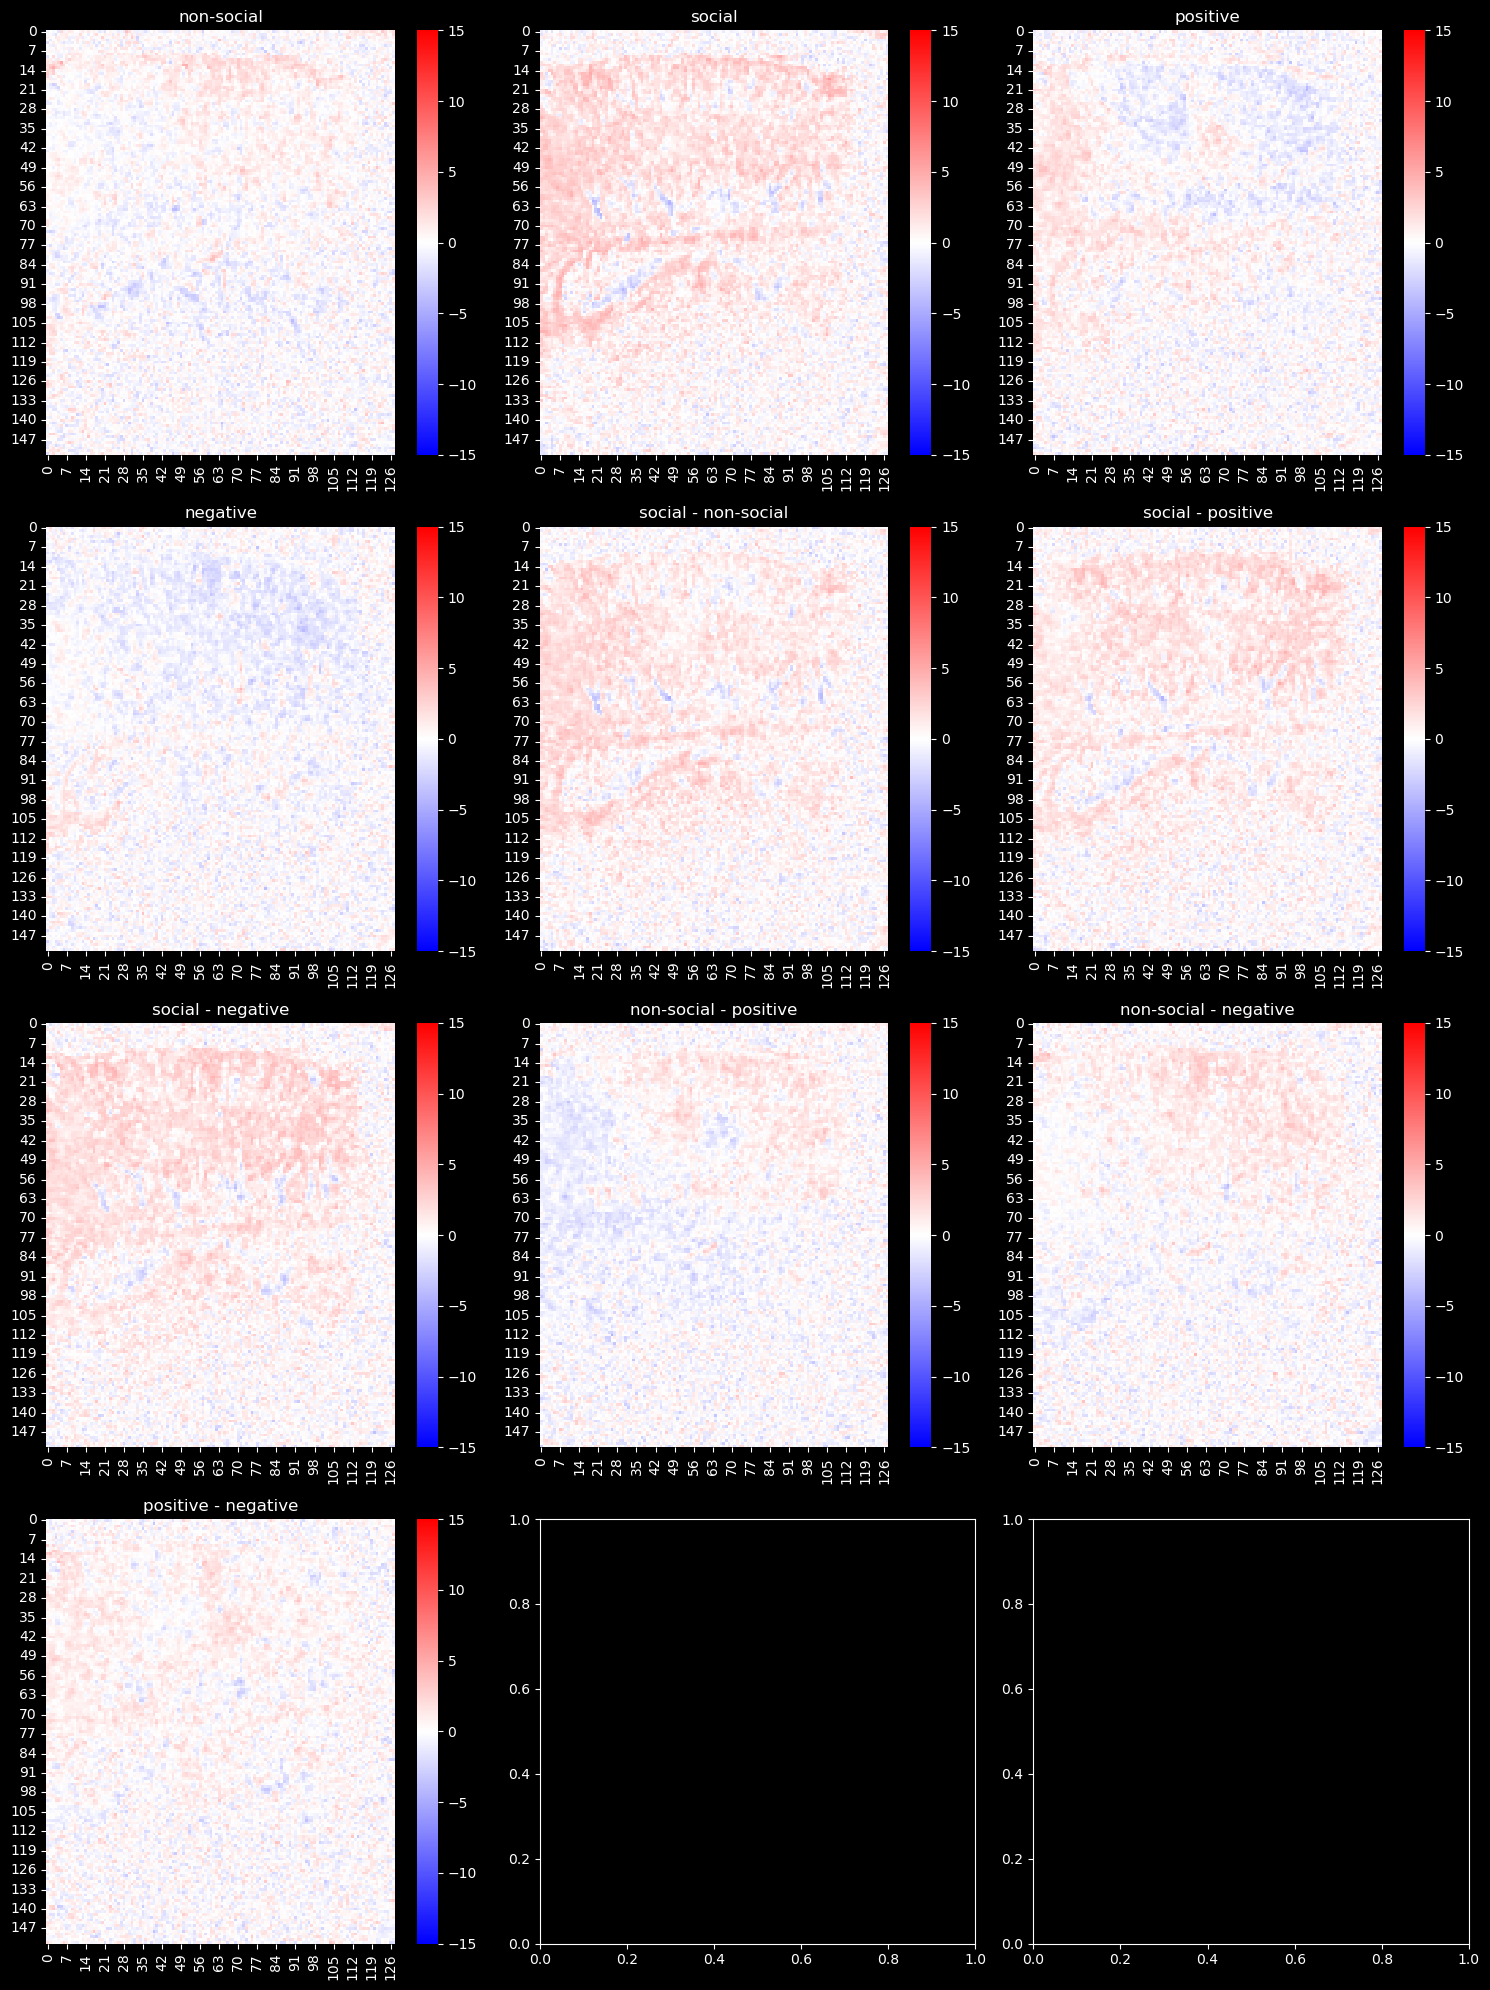

In [121]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_Audiocue_data/same_plane/Zion_video_audio_0220'
brain_filename = 'Zion_Social_Videos_New_0220_2Dscan_1_fus2D.source.nii'
event_filename = 'mldata.mat'

run_glm_analysis(data_dir, brain_filename, event_filename, task_type='video', vmin=-15, vmax=15)


In [127]:
def proc_pixel(pixel_data, event_df, tr=1/2.5):
    trial_data = get_trial_data(event_df, pixel_data, tr)
    trial_types = [str(x) for x in range(1, 7)]
    normalized_data = []

    for trial_type in trial_types:
        data = trial_data[event_df['trial_type'] == trial_type]
        normalized_data.append(normalize_data(data))

    return normalized_data 

In [131]:
task_type='video'

brain_data, event_mat = load_data(data_dir, brain_filename, event_filename, task_type)
condition, behave_codes, absolute_starttime = extract_event_info(event_mat, task_type)
event_df = create_design_matrix(condition, behave_codes, absolute_starttime, task_type)

tr = 1 / 2.5
n_tr = brain_data.shape[-1]
frame_times = np.arange(n_tr) * tr

event_df1, event_binary_df = map_events_to_frame_times(event_df, frame_times)

i, j = 56, 25
pixel_data = brain_data[i,0,j,:].reshape(-1,1)
normalized_data = proc_pixel(pixel_data, event_df1)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 153, 4500)


/var/folders/xh/0b2t8trn63n0nz_9qb97s_940000gn/T/ipykernel_38575/1743092044.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(normalized_data[2], axis=0), label='Non-social', alpha=0.5)


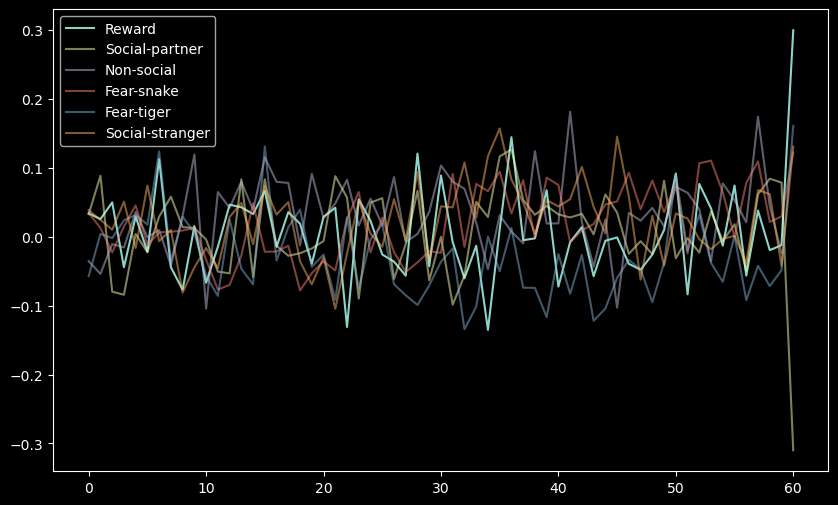

In [132]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the three lines
plt.plot(np.nanmean(normalized_data[0], axis=0), label='Reward')  
plt.plot(np.nanmean(normalized_data[1], axis=0), label='Social-partner', alpha=0.5) 
plt.plot(np.nanmean(normalized_data[2], axis=0), label='Non-social', alpha=0.5)
plt.plot(np.nanmean(normalized_data[3], axis=0), label='Fear-snake', alpha=0.5)
plt.plot(np.nanmean(normalized_data[4], axis=0), label='Fear-tiger', alpha=0.5)
plt.plot(np.nanmean(normalized_data[5], axis=0), label='Social-stranger', alpha=0.5)


# # Adding titles and labels
# plt.title('Three Lines in One Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')

# Add a legend
plt.legend()

# Show the plot
plt.show()

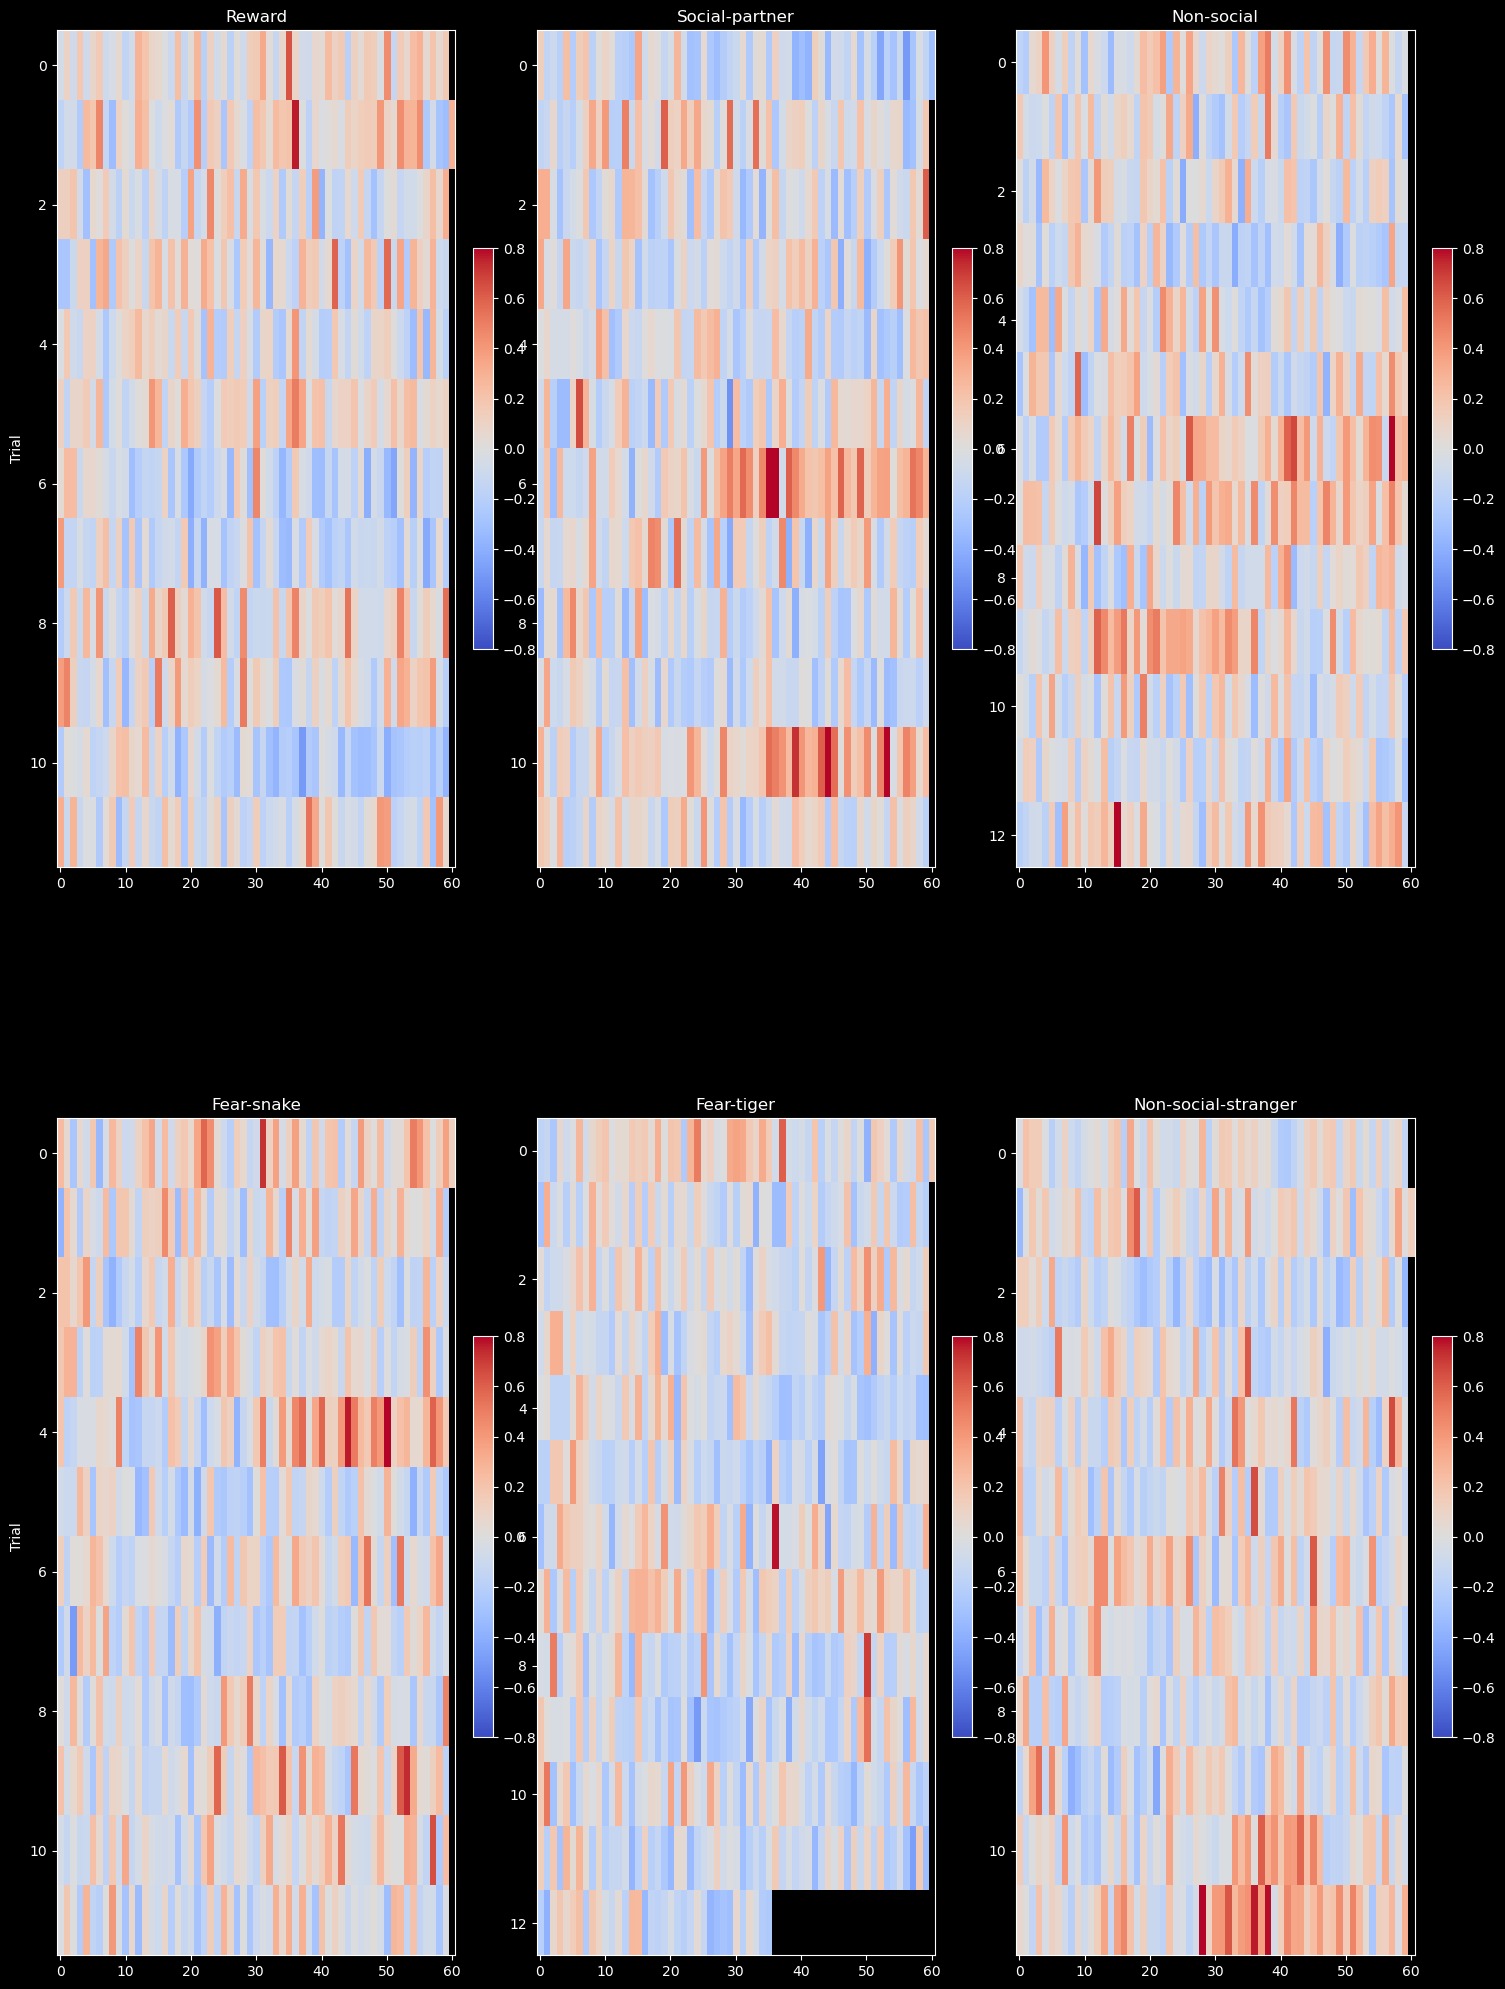

In [133]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 25))  # Adjust the figure size to accommodate six plots

# Use GridSpec to control the layout
gs = GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1], wspace=0.1, hspace=0.3)  # Two rows, three columns

min_val = -0.8
max_val = 0.8

# First plot (reward_data)
ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(normalized_data[0], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax0.set_title('Reward')
ax0.set_ylabel('Trial')

# Second plot (airpuff_data)
ax1 = fig.add_subplot(gs[0, 1])
im1 = ax1.imshow(normalized_data[1], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax1.set_title('Social-partner')

# Third plot (idle_data)
ax2 = fig.add_subplot(gs[0, 2])
im2 = ax2.imshow(normalized_data[2], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax2.set_title('Non-social')

# Fourth plot (additional_data_1)
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.imshow(normalized_data[3], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax3.set_title('Fear-snake')
ax3.set_ylabel('Trial')

# Fifth plot (additional_data_2)
ax4 = fig.add_subplot(gs[1, 1])
im4 = ax4.imshow(normalized_data[4], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax4.set_title('Fear-tiger')

# Sixth plot (additional_data_3)
ax5 = fig.add_subplot(gs[1, 2])
im5 = ax5.imshow(normalized_data[5], cmap='coolwarm', aspect='auto', vmin=min_val, vmax=max_val)
ax5.set_title('Non-social-stranger')

# Add colorbars (optional)
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
plt.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)

plt.show()


## Zion 02/29/24

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 153, 4500)


/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset
  warnings.warn(


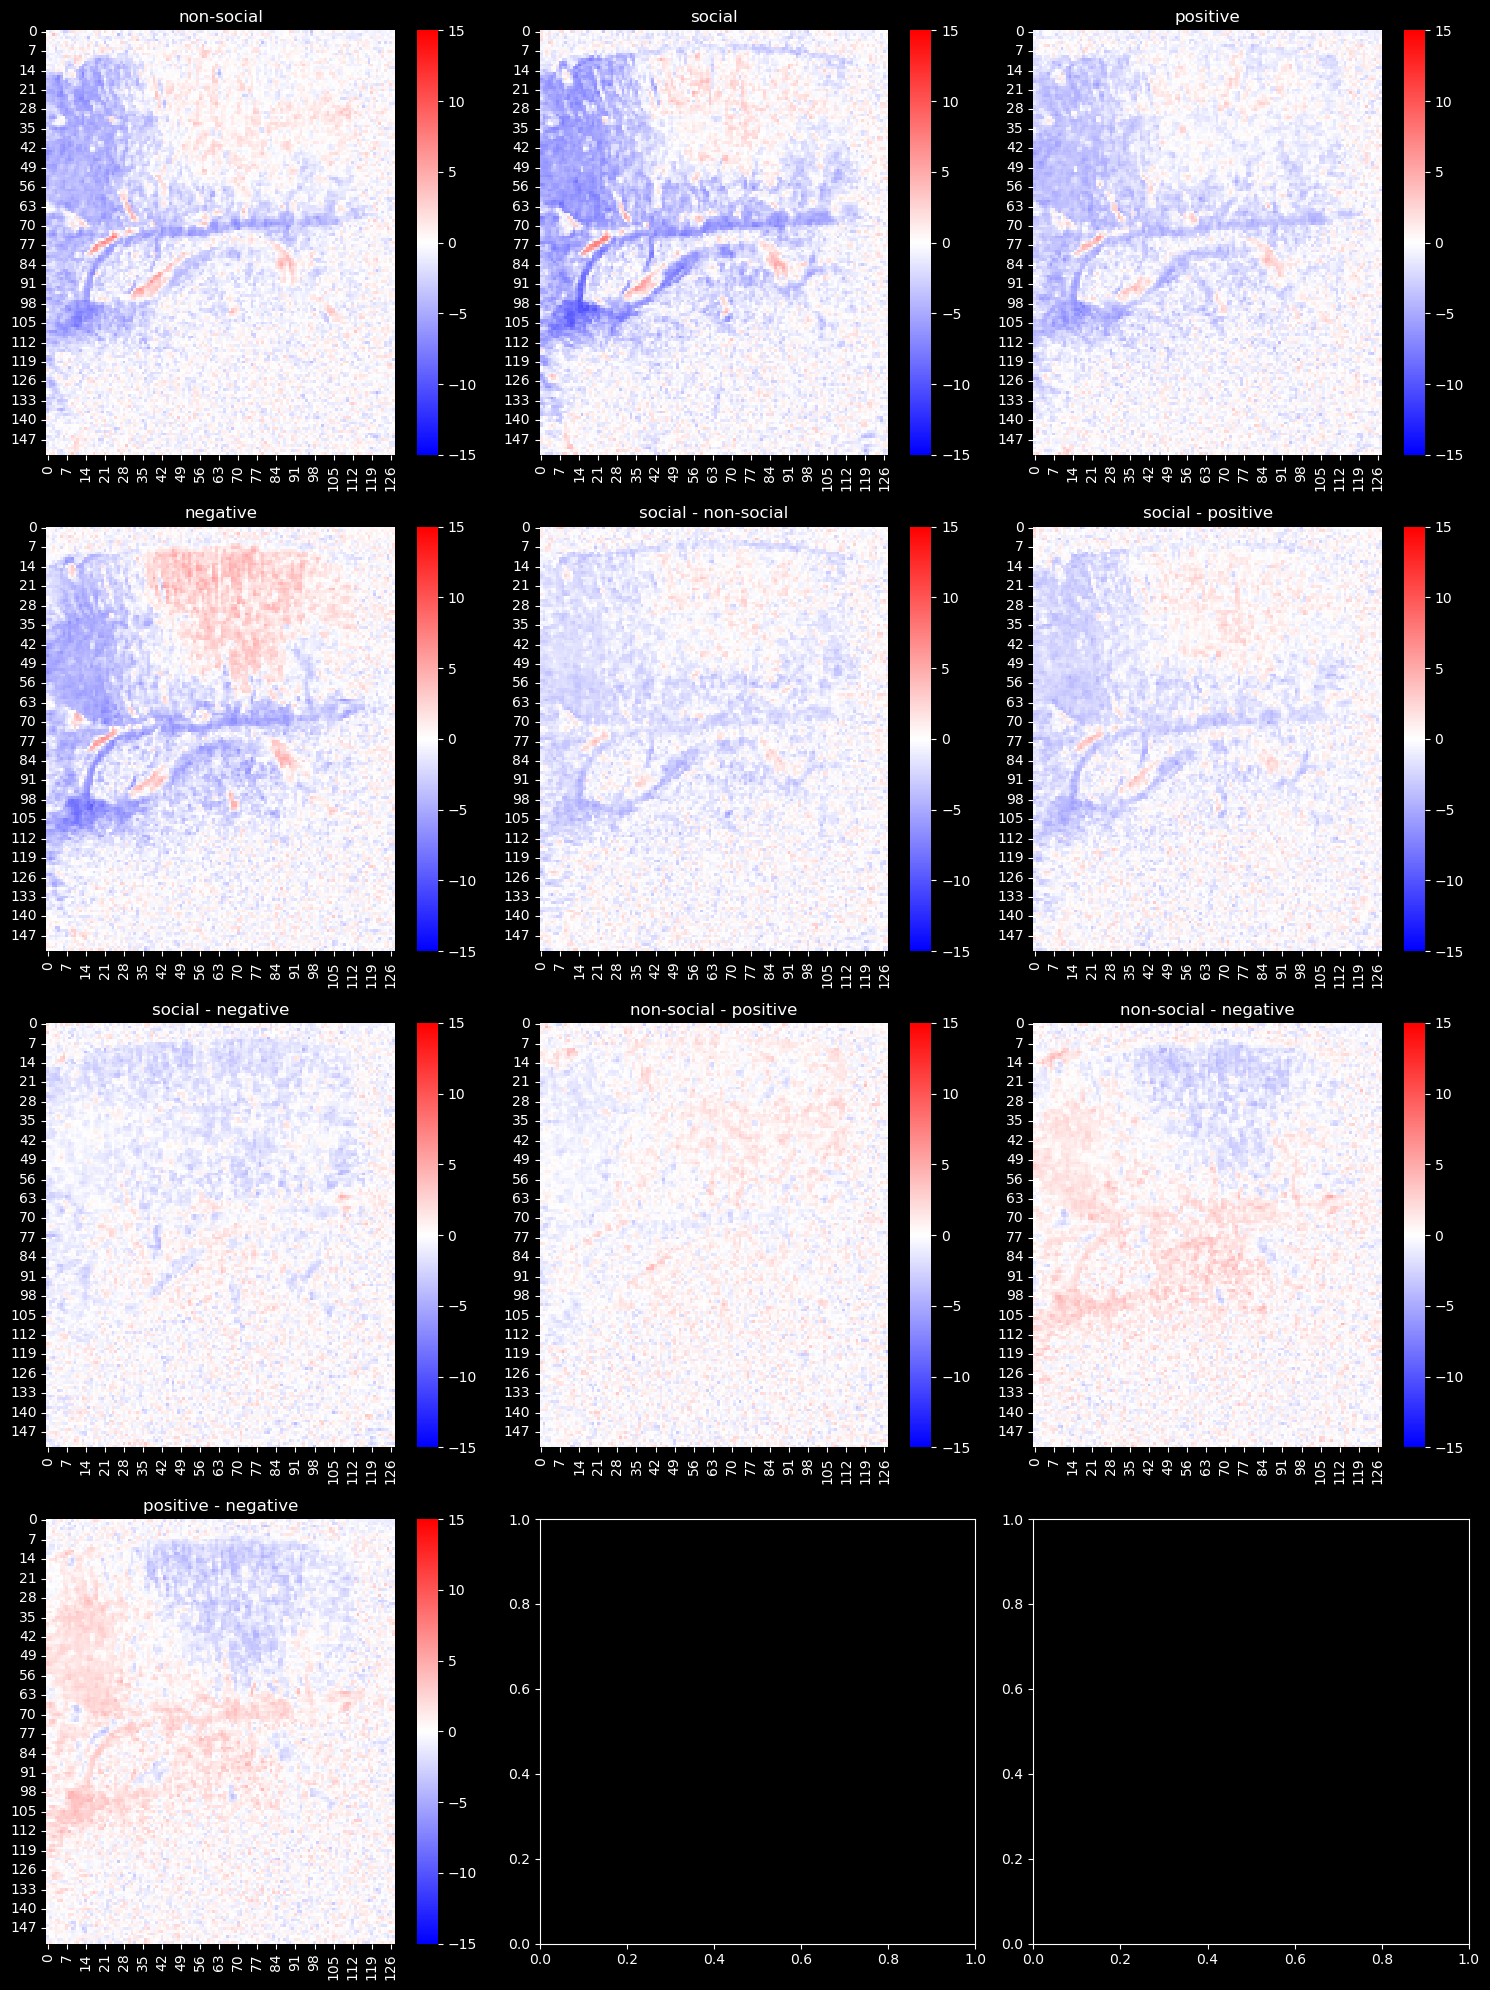

In [109]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/Grouper_Audiocue_data/same_plane/Zion_video_audio_0229'
brain_filename = 'Zion__Social_video_0229_2.5Hz_2Dscan_1_fus2D.source.nii'
event_filename = 'mldata.mat'

run_glm_analysis(data_dir, brain_filename, event_filename, task_type='video', vmin=-15, vmax=15)


# Audio

pixdim[1,2,3] should be positive; setting to abs of pixdim values
/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset
  warnings.warn(


Brain data shape: (128, 1, 153, 4500)


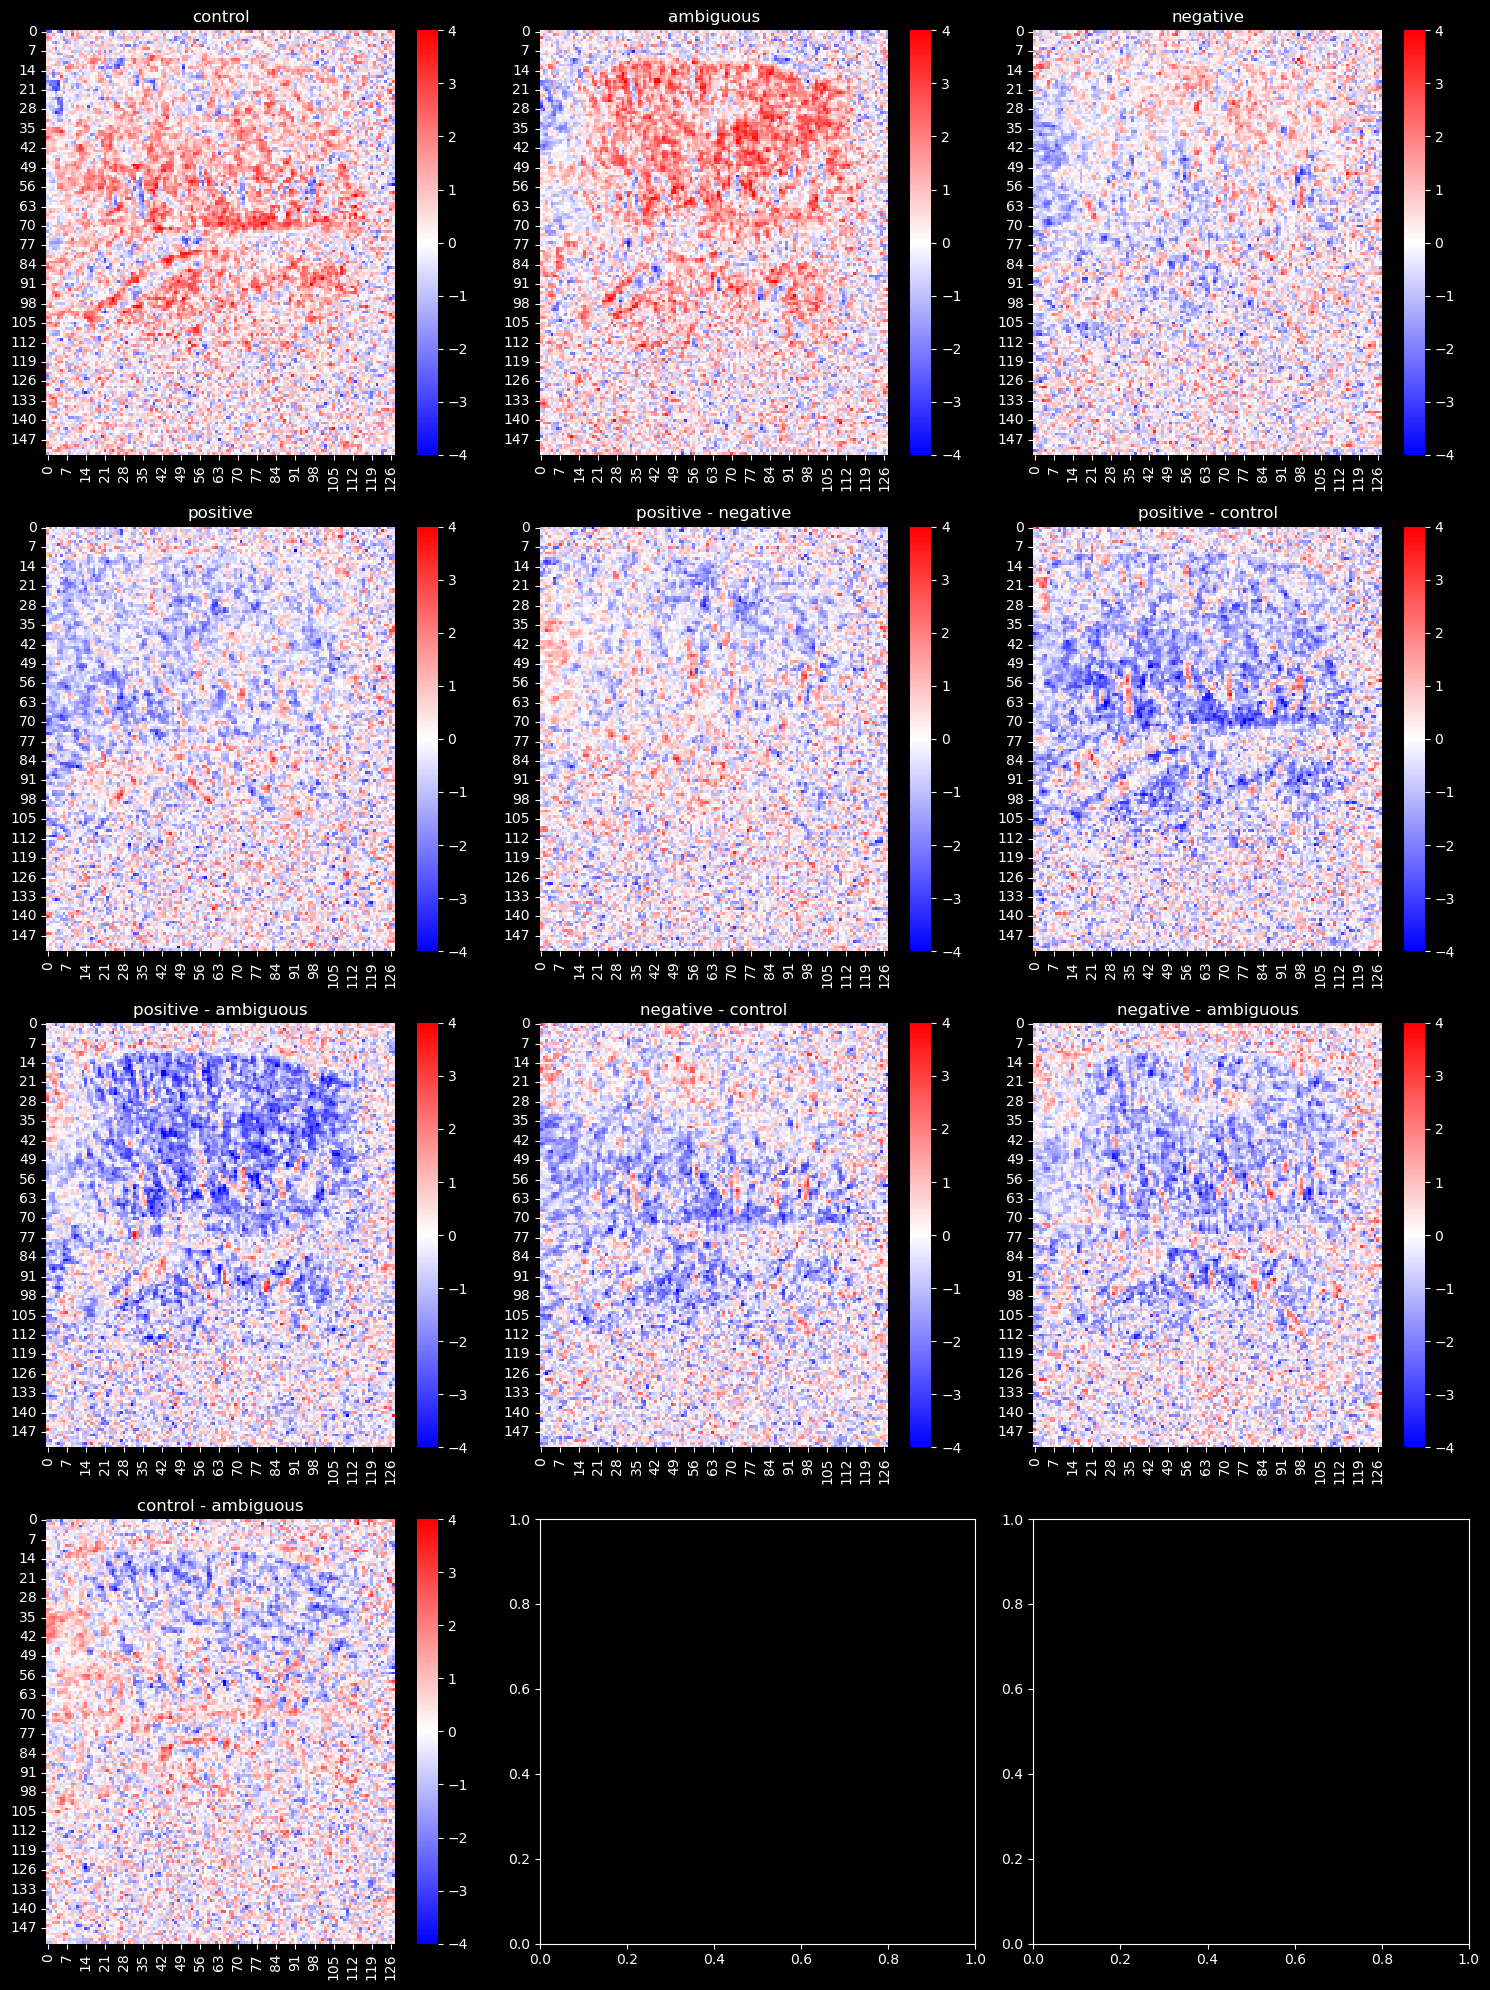

In [107]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/same_plane/Zion_video_audio_0220'
brain_filename = 'Zion_MarmoAudio_0220_2Dscan_2_fus2D.source.nii'
event_filename = 'mldata.mat'

run_glm_analysis(data_dir, brain_filename, event_filename, task_type='audio', vmin=-4, vmax=4)


## Zion 02/29/24

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 153, 4500)


/Users/yibeichen/micromamba/envs/neuro/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: raw_onset
  warnings.warn(


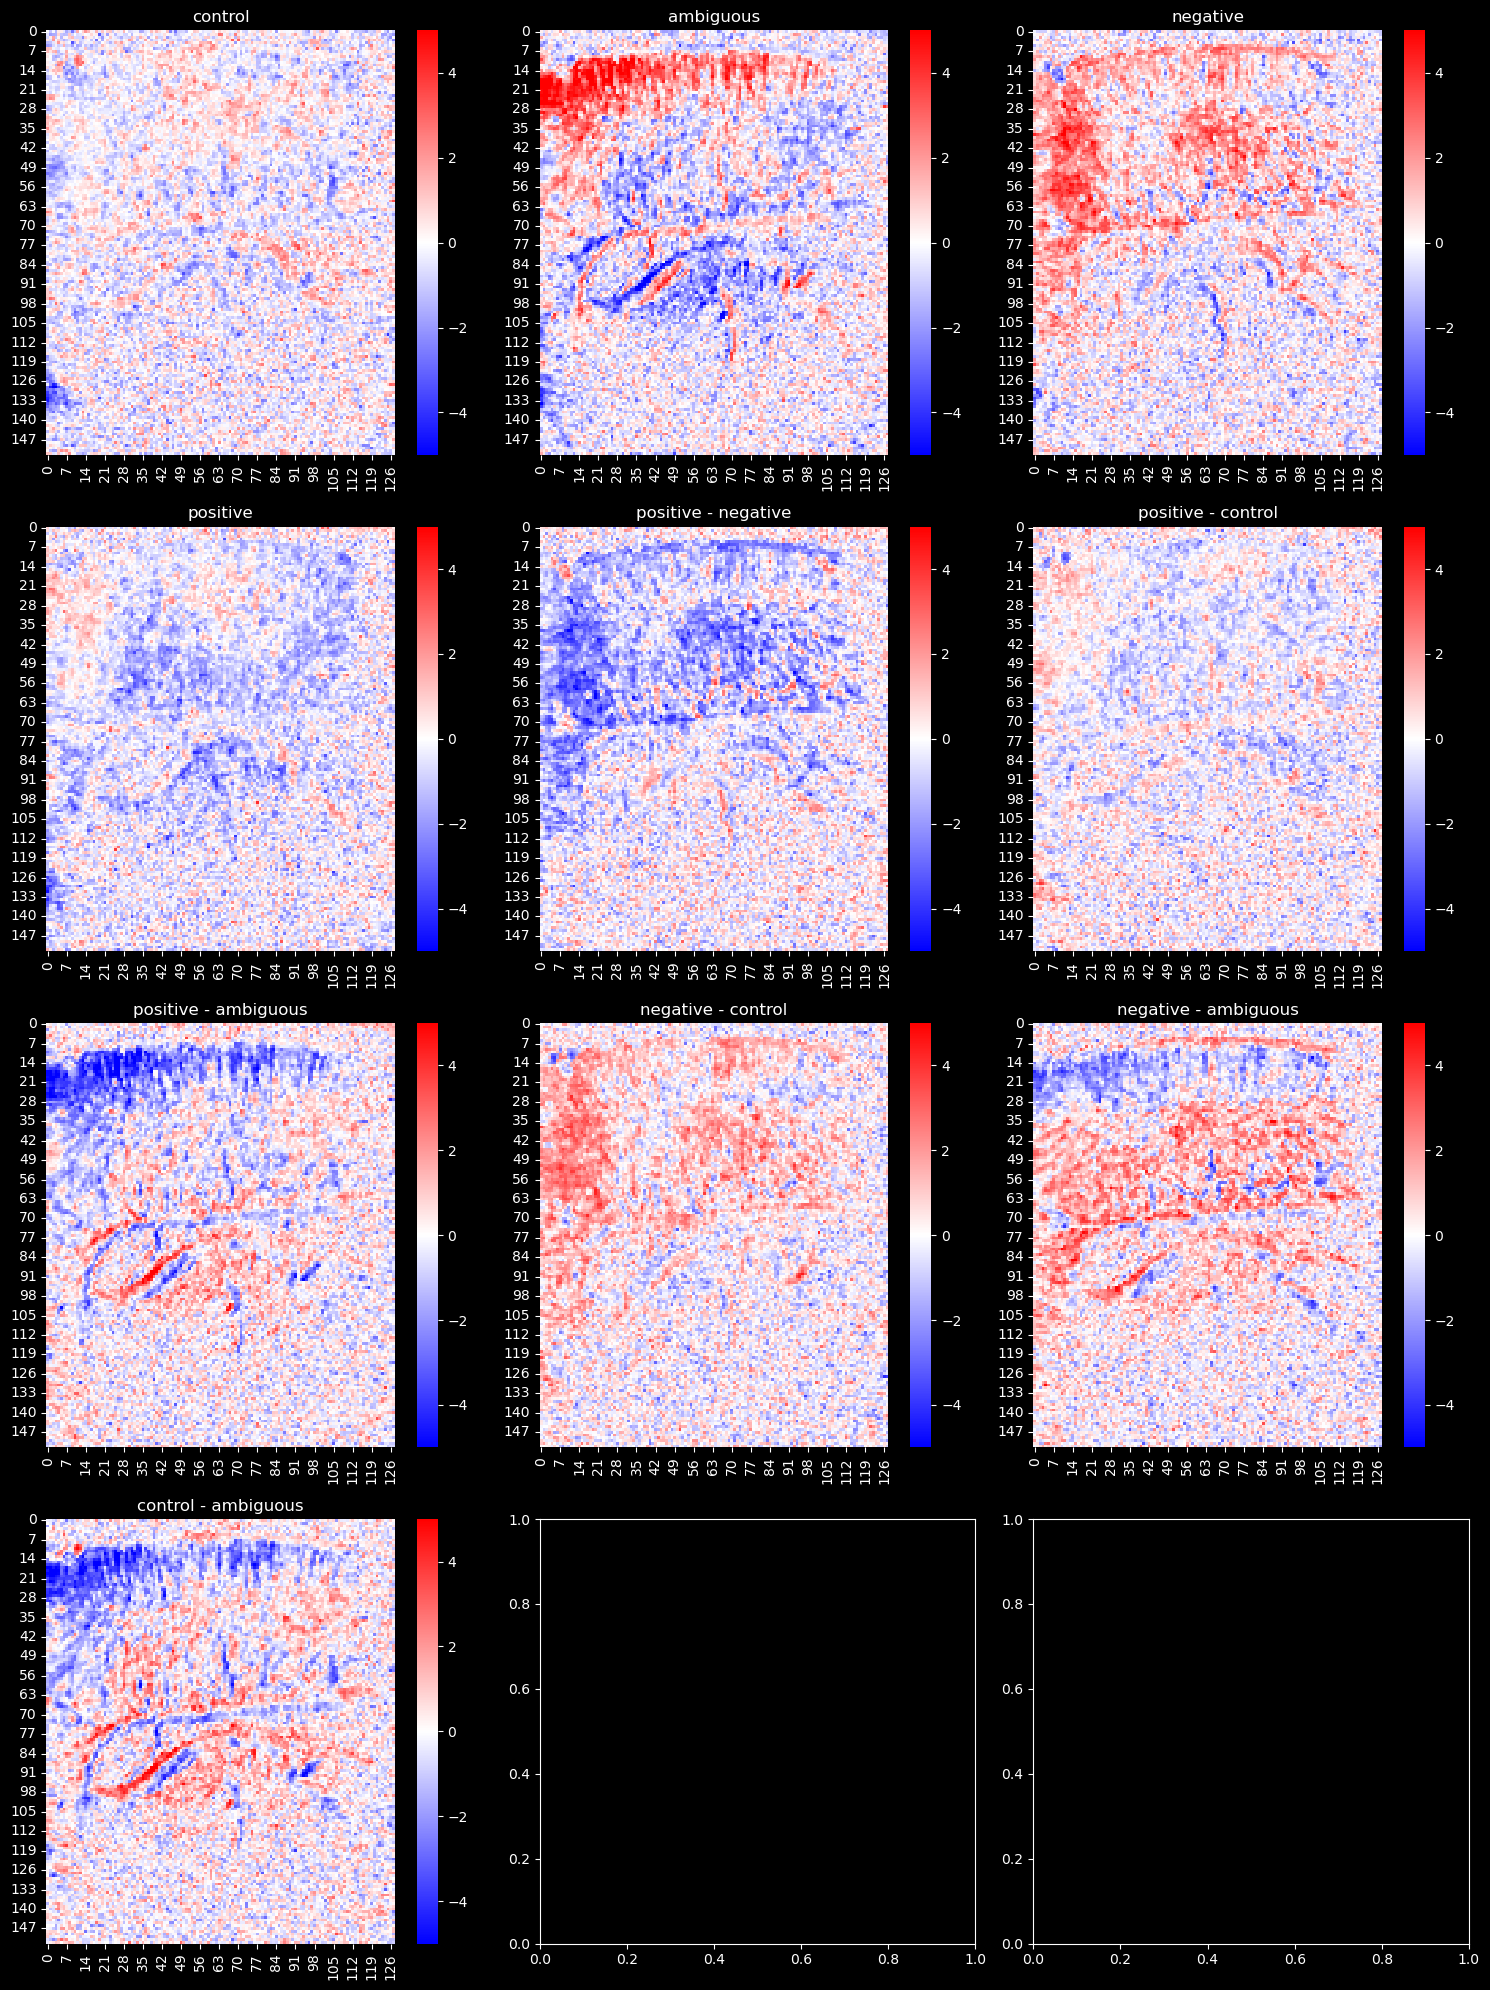

In [106]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data/same_plane/Zion_video_audio_0229'
brain_filename = 'Zion_Marmo_Audio_Chaoyi_0229_2.5Hz_2Dscan_2_fus2D.source.nii'
event_filename = 'mldata.mat'

run_glm_analysis(data_dir, brain_filename, event_filename, task_type='audio', vmin=-5, vmax=5)
